### Student Name: Hilton Sarius
### Course: MAI5301 - Foundations Of Large Language Models
### Activity: Assigment #1

In [1]:
!git clone https://github.com/rasbt/LLMs-from-scratch.git

Cloning into 'LLMs-from-scratch'...
remote: Enumerating objects: 7777, done.
remote: Counting objects: 100% (188/188), done.
remote: Compressing objects: 100% (132/132), done.
remote: Total 7777 (delta 136), reused 56 (delta 56), pack-reused 7589 (from 4)
Receiving objects: 100% (7777/7777), 15.42 MiB | 16.80 MiB/s, done.
Resolving deltas: 100% (4411/4411), done.


In [2]:
!pip install torch numpy matplotlib tiktoken
!pip install tqdm tensorboard

In [3]:
import re

In [24]:
import re
from collections import Counter
from itertools import count

class SimpleTokenizer:
    TOKEN_PATTERN = re.compile(r"\w+|[^\w\s]", re.UNICODE)
    PUNCT_PATTERN = re.compile(r"[^\w\s]", re.UNICODE)

    def __init__(self, vocab=None, unk_token="<unk>"):
        self.unk_token = unk_token
        self.vocab = vocab if vocab is not None else {unk_token: 0}
        self._rebuild_inverse()

    def _rebuild_inverse(self):
        self.inv_vocab = {idx: tok for tok, idx in self.vocab.items()}

    def _tokenize(self, text: str):
        # same behavior: words + punctuation
        return self.TOKEN_PATTERN.findall(text)

    def build_vocab(self, texts, min_freq=1):
        counter = Counter()
        for text in texts:
            counter.update(self._tokenize(text))

        # reset vocab, always reserve unk at 0
        self.vocab = {self.unk_token: 0}

        # assign IDs starting from 1
        next_id = count(start=1)
        for token, freq in counter.items():
            if freq >= min_freq and token not in self.vocab:
                self.vocab[token] = next(next_id)

        self._rebuild_inverse()

    def encode(self, text: str):
        unk_id = self.vocab[self.unk_token]
        return [self.vocab.get(tok, unk_id) for tok in self._tokenize(text)]

    def _detokenize(self, tokens):
        # same spacing rules as original:
        # - punctuation attaches to previous
        # - words separated by spaces
        out = []
        for tok in tokens:
            if self.PUNCT_PATTERN.match(tok):
                if out:
                    out[-1] += tok
                else:
                    out.append(tok)
            else:
                out.append(tok)
        return " ".join(out)

    def decode(self, ids):
        tokens = [self.inv_vocab.get(i, self.unk_token) for i in ids]
        return self._detokenize(tokens)


In [25]:
sample_text = "Hello world! This is a test."

tok = SimpleTokenizer()
tok.build_vocab([sample_text])

def run_demo(text: str, label: str = "Text"):
    print(f"{label}:", text)

    tokens = tok._tokenize(text)
    print("Tokens:", tokens)

    ids = tok.encode(text)
    print("Encoded IDs:", ids)

    decoded = tok.decode(ids)
    print("Decoded:", decoded)

    return ids, decoded


# --- Main demo ---
print("Original:", sample_text)
run_demo(sample_text, "Original")

# --- Unknown token test ---
unknown_text = "Hello unknownword!!!"
print("\nUnknown test text:", unknown_text)

unknown_ids, unknown_decoded = run_demo(unknown_text, "Unknown")
print("Unknown decoded:", unknown_decoded)

# --- Vocab size ---
print("\nVocab size:", len(tok.vocab))


Original: Hello world! This is a test.
Original: Hello world! This is a test.
Tokens: ['Hello', 'world', '!', 'This', 'is', 'a', 'test', '.']
Encoded IDs: [1, 2, 3, 4, 5, 6, 7, 8]
Decoded: Hello world! This is a test.

Unknown test text: Hello unknownword!!!
Unknown: Hello unknownword!!!
Tokens: ['Hello', 'unknownword', '!', '!', '!']
Encoded IDs: [1, 0, 3, 3, 3]
Decoded: Hello<unk>!!!
Unknown decoded: Hello<unk>!!!

Vocab size: 9


Top 10 most frequent token IDs:
ID 995    Count 30     TokenPiece ' world'
ID 0      Count 30     TokenPiece '!'
ID 770    Count 30     TokenPiece ' This'
ID 318    Count 30     TokenPiece ' is'
ID 257    Count 30     TokenPiece ' a'
ID 1332   Count 30     TokenPiece ' test'
ID 13     Count 30     TokenPiece '.'
ID 18435  Count 29     TokenPiece ' Hello'
ID 15496  Count 1      TokenPiece 'Hello'
ID 220    Count 1      TokenPiece ' '


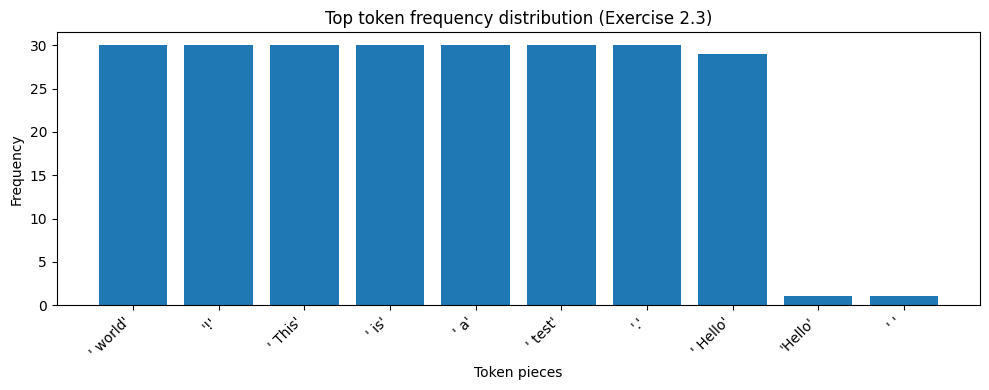

In [26]:
# Exercise 2.3: Analyze token frequency distribution in your dataset

import matplotlib.pyplot as plt
from collections import Counter
import tiktoken


def get_top_tokens(enc, text: str, top_n: int = 20):
    ids = enc.encode(text)
    freq = Counter(ids)
    return freq.most_common(top_n)


def print_top_tokens(enc, most_common):
    print(f"Top {len(most_common)} most frequent token IDs:")
    for tid, cnt in most_common:
        token_piece = enc.decode([tid])
        print(f"ID {tid:<6} Count {cnt:<6} TokenPiece {repr(token_piece)}")


def plot_token_freq(enc, most_common, title: str):
    decoded = [(enc.decode([tid]), cnt) for tid, cnt in most_common]
    labels = [repr(piece) for piece, _ in decoded]   # safer for whitespace tokens
    counts = [cnt for _, cnt in decoded]

    plt.figure(figsize=(10, 4))
    plt.bar(range(len(counts)), counts)
    plt.xticks(range(len(labels)), labels, rotation=45, ha="right")
    plt.xlabel("Token pieces")
    plt.ylabel("Frequency")
    plt.title(title)
    plt.tight_layout()
    plt.show()


def main():
    enc = tiktoken.get_encoding("gpt2")

    ex_text = "Hello world! This is a test. " * 30
    top_n = 20

    most_common = get_top_tokens(enc, ex_text, top_n=top_n)
    print_top_tokens(enc, most_common)
    plot_token_freq(enc, most_common, title="Top token frequency distribution (Exercise 2.3)")


if __name__ == "__main__":
    main()


In [9]:
import matplotlib.pyplot as plt

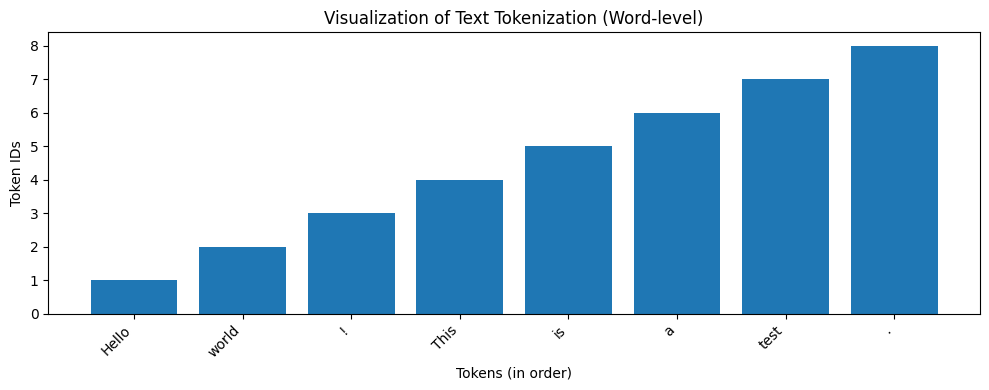

In [27]:
# Alternative implementation (same logic)

ids = tok.encode(sample_text)
positions, labels = zip(*enumerate(tokens))  # positions: 0..n-1, labels: tokens

plt.figure(figsize=(10, 4))
plt.bar(positions, ids)
plt.xticks(positions, labels, rotation=45, ha="right")
plt.xlabel("Tokens (in order)")
plt.ylabel("Token IDs")
plt.title("Visualization of Text Tokenization (Word-level)")
plt.tight_layout()
plt.show()


In [28]:
print("Original text:")
print(sample_text)

print("\nTokenization visualization:\n")

# Dynamic column width for nicer formatting
token_col_width = max(15, max(len(str(t)) for t in tokens))

header = f"{'#':>3} | {'Token':<{token_col_width}} | Token ID"
print(header)
print("-" * len(header))

for idx, (tok_text, tok_id) in enumerate(zip(tokens, ids)):
    print(f"{idx:>3} | {tok_text:<{token_col_width}} | {tok_id}")


Original text:
Hello world! This is a test.

Tokenization visualization:

  # | Token           | Token ID
--------------------------------
  0 | Hello           | 1
  1 | world           | 2
  2 | !               | 3
  3 | This            | 4
  4 | is              | 5
  5 | a               | 6
  6 | test            | 7
  7 | .               | 8


In [13]:
!pip -q install tiktoken
import tiktoken

In [14]:
enc = tiktoken.get_encoding("gpt2")

In [29]:
text = "Hello world! This is a test."

ids = enc.encode(text)
decoded = enc.decode(ids)

print(f"Original: {text}")
print(f"BPE IDs:   {ids}")
print(f"Decoded:  {decoded}")


Original: Hello world! This is a test.
BPE IDs:   [15496, 995, 0, 770, 318, 257, 1332, 13]
Decoded:  Hello world! This is a test.


In [30]:
def print_section(title: str):
    print(f"\n{title}")
    print("-" * len(title))

def show_simple(tok, text: str):
    tokens = tok._tokenize(text)
    ids = tok.encode(text)
    decoded = tok.decode(ids)

    print_section("SimpleTokenizer")
    print("Tokens:", tokens)
    print("Num tokens:", len(tokens))
    print("IDs:", ids)
    print("Decoded:", decoded)

    return tokens, ids

def show_bpe(enc, text: str):
    ids = enc.encode(text)
    pieces = [enc.decode([i]) for i in ids]
    decoded = enc.decode(ids)

    print_section("tiktoken GPT-2 BPE")
    print("Token pieces:", pieces)
    print("Num tokens:", len(ids))
    print("IDs:", ids)
    print("Decoded:", decoded)

    return pieces, ids


# --- Run comparison ---
print("TEXT:")
print(text)

simple_tokens, simple_ids = show_simple(tok, text)
bpe_pieces, bpe_ids = show_bpe(enc, text)

print_section("Quick comparison summary")
print("SimpleTokenizer token count:", len(simple_tokens))
print("BPE token count:", len(bpe_ids))


TEXT:
Hello world! This is a test.

SimpleTokenizer
---------------
Tokens: ['Hello', 'world', '!', 'This', 'is', 'a', 'test', '.']
Num tokens: 8
IDs: [1, 2, 3, 4, 5, 6, 7, 8]
Decoded: Hello world! This is a test.

tiktoken GPT-2 BPE
------------------
Token pieces: ['Hello', ' world', '!', ' This', ' is', ' a', ' test', '.']
Num tokens: 8
IDs: [15496, 995, 0, 770, 318, 257, 1332, 13]
Decoded: Hello world! This is a test.

Quick comparison summary
------------------------
SimpleTokenizer token count: 8
BPE token count: 8


In [31]:
print(f"GPT-2 BPE vocab size (enc.n_vocab): {enc.n_vocab}")

example_ids = [0, 1, 2, 10, 100, 1000]

print("\nExample token ID -> token piece")
print("-" * 32)

for tid in example_ids:
    piece = enc.decode([tid])
    print(f"{tid:>5} -> {repr(piece)}")


GPT-2 BPE vocab size (enc.n_vocab): 50257

Example token ID -> token piece
--------------------------------
    0 -> '!'
    1 -> '"'
    2 -> '#'
   10 -> '+'
  100 -> '�'
 1000 -> 'ale'


In [32]:
special_text = "Hello world! <|endoftext|>"
allowed = {"<|endoftext|>"}

ids_special = enc.encode(special_text, allowed_special=allowed)
decoded_special = enc.decode(ids_special)

print(f"Special text: {special_text}")
print(f"Special IDs:  {ids_special}")
print(f"Decoded:      {decoded_special}")


Special text: Hello world! <|endoftext|>
Special IDs:  [15496, 995, 0, 220, 50256]
Decoded:      Hello world! <|endoftext|>


In [33]:
# Exercise 2.1: Character-level tokenizer & vocab size comparison with BPE

def char_tokenize(text: str):
    return list(text)

def build_char_vocab(tokens):
    return sorted(set(tokens))

ex_text = "This is a tiny dataset for comparison. " * 10

# --- Character-level analysis ---
char_tokens = char_tokenize(ex_text)
char_vocab = build_char_vocab(char_tokens)

# --- BPE analysis ---
bpe_ids_ex = enc.encode(ex_text)
bpe_pieces_preview = [enc.decode([i]) for i in bpe_ids_ex[:20]]

# --- Output ---
print("Exercise 2.1 text sample length (chars):", len(ex_text))
print("Character vocab size:", len(char_vocab))
print("First 30 char vocab symbols:", char_vocab[:30])

print("\nBPE vocab size (fixed GPT-2):", enc.n_vocab)
print("BPE token count for sample:", len(bpe_ids_ex))
print("First 20 BPE token pieces:", bpe_pieces_preview)


Exercise 2.1 text sample length (chars): 390
Character vocab size: 18
First 30 char vocab symbols: [' ', '.', 'T', 'a', 'c', 'd', 'e', 'f', 'h', 'i', 'm', 'n', 'o', 'p', 'r', 's', 't', 'y']

BPE vocab size (fixed GPT-2): 50257
BPE token count for sample: 81
First 20 BPE token pieces: ['This', ' is', ' a', ' tiny', ' dataset', ' for', ' comparison', '.', ' This', ' is', ' a', ' tiny', ' dataset', ' for', ' comparison', '.', ' This', ' is', ' a', ' tiny']


In [20]:
import torch
from torch.utils.data import Dataset, DataLoader

In [34]:
import torch
from torch.utils.data import Dataset

class SlidingWindowDataset(Dataset):
    def __init__(self, token_ids, context_length: int, stride: int = 1):
        if context_length < 1:
            raise ValueError("context_length must be >= 1")
        if stride < 1:
            raise ValueError("stride must be >= 1")

        self.token_ids = token_ids
        self.context_length = context_length
        self.stride = stride

        # We need context_length + 1 tokens to form (x, y) where y is shifted by 1.
        self.seq_len = context_length + 1

        max_start = len(token_ids) - self.seq_len
        if max_start < 0:
            raise ValueError("Not enough tokens to create even one sample.")

        # Precompute all valid window start positions
        self.start_positions = list(range(0, max_start + 1, stride))

    def __len__(self):
        return len(self.start_positions)

    def __getitem__(self, idx):
        start = self.start_positions[idx]
        window = self.token_ids[start : start + self.seq_len]

        x = window[:-1]  # length = context_length
        y = window[1:]   # shifted by 1

        return (
            torch.as_tensor(x, dtype=torch.long),
            torch.as_tensor(y, dtype=torch.long),
        )


In [35]:
text = "This is a tiny dataset for sliding window sampling. " * 50
token_ids = enc.encode(text)

context_length = 16
stride = 4

ds = SlidingWindowDataset(token_ids, context_length=context_length, stride=stride)
print("Number of samples:", len(ds))

def ids_to_text(ids):
    return enc.decode(ids if isinstance(ids, list) else ids.tolist())

# Inspect the first sample
x0, y0 = ds[0]

print("\nFirst sample shapes:", tuple(x0.shape), tuple(y0.shape))
print("x0:", x0.tolist())
print("y0:", y0.tolist())

print("\nDecoded x0:", ids_to_text(x0))
print("\nDecoded y0:", ids_to_text(y0))


Number of samples: 122

First sample shapes: (16,) (16,)
x0: [1212, 318, 257, 7009, 27039, 329, 22292, 4324, 19232, 13, 770, 318, 257, 7009, 27039, 329]
y0: [318, 257, 7009, 27039, 329, 22292, 4324, 19232, 13, 770, 318, 257, 7009, 27039, 329, 22292]

Decoded x0: This is a tiny dataset for sliding window sampling. This is a tiny dataset for

Decoded y0:  is a tiny dataset for sliding window sampling. This is a tiny dataset for sliding


In [36]:
batch_size = 8
loader = DataLoader(ds, batch_size=batch_size, shuffle=True, drop_last=True)

it = iter(loader)
xb, yb = next(it)

print(f"Batch x shape: {tuple(xb.shape)}")
print(f"Batch y shape: {tuple(yb.shape)}")

print("\nBatch x:\n", xb)
print("\nBatch y:\n", yb)

decode_ids = lambda t: enc.decode(t.tolist())

print("\nDecoded batch x (first item):", decode_ids(xb[0]))
print("\nDecoded batch y (first item):", decode_ids(yb[0]))


Batch x shape: (8, 16)
Batch y shape: (8, 16)

Batch x:
 tensor([[19232,    13,   770,   318,   257,  7009, 27039,   329, 22292,  4324,
         19232,    13,   770,   318,   257,  7009],
        [19232,    13,   770,   318,   257,  7009, 27039,   329, 22292,  4324,
         19232,    13,   770,   318,   257,  7009],
        [22292,  4324, 19232,    13,   770,   318,   257,  7009, 27039,   329,
         22292,  4324, 19232,    13,   770,   318],
        [  770,   318,   257,  7009, 27039,   329, 22292,  4324, 19232,    13,
           770,   318,   257,  7009, 27039,   329],
        [19232,    13,   770,   318,   257,  7009, 27039,   329, 22292,  4324,
         19232,    13,   770,   318,   257,  7009],
        [27039,   329, 22292,  4324, 19232,    13,   770,   318,   257,  7009,
         27039,   329, 22292,  4324, 19232,    13],
        [19232,    13,   770,   318,   257,  7009, 27039,   329, 22292,  4324,
         19232,    13,   770,   318,   257,  7009],
        [19232,    13,   7